# Reto Final - Notebook Individual Saulo Nuez Ortega

## Importando  y analizando conjunto de datos

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('dataset.csv')
test = pd.read_csv('test_nolabel.csv')

data.head()

,label,text
0,0,"Hi Roy hope you are ok, Trans people are not g..."
1,0,But fuckin' hell what even is biology
2,0,Whose the nice looking clergyman?
3,1,"AIDS ARE IN YOUR WAY, SIN HAS CONSEQUENCES AND..."
4,0,to learn


### Analisis de los datos

/tmp/ipykernel_13172/31409169.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo_labels.index, y=conteo_labels.values, palette='viridis')


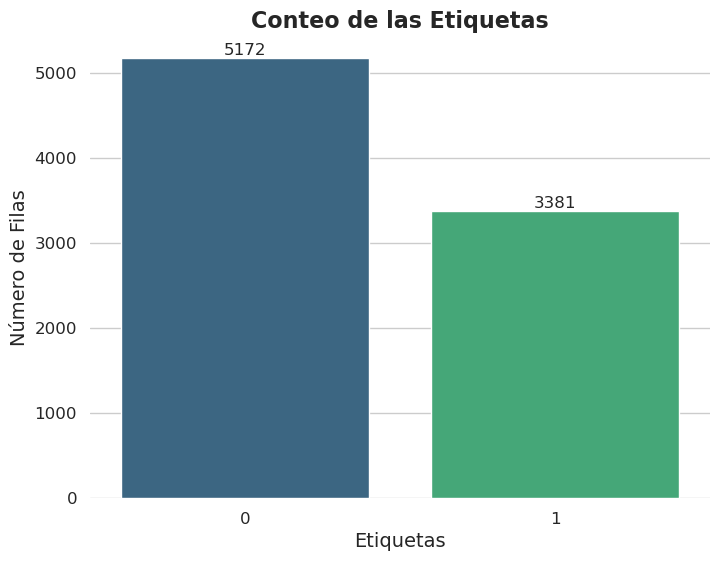

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

conteo_labels = data['label'].value_counts()

sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=conteo_labels.index, y=conteo_labels.values, palette='viridis')

plt.title('Conteo de las Etiquetas', fontsize=16, fontweight='bold')
plt.xlabel('Etiquetas', fontsize=14)
plt.ylabel('Número de Filas', fontsize=14)

for i in range(len(conteo_labels)):
    ax.text(i, conteo_labels[i] + 0.05, str(conteo_labels[i]), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)


plt.show()

In [4]:
!pip install nltk

In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [9]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [ ]:
#!pip install mlflow

In [ ]:
#!pip install --upgrade numpy tensorflow keras mlflow

In [15]:
import subprocess
import sys
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
import numpy as np
import pandas as pd
from mlflow.data.pandas_dataset import PandasDataset

import tensorflow as tf
# Verifica las versiones de numpy y tensorflow
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

# Verificar la instalación de h5py
try:
    import h5py
    print("h5py está instalado correctamente.")
except ImportError:
    print("h5py no está instalado. Intenta instalarlo nuevamente.")

X = data['text'].values
y = data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Creación del modelo RNN
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
max_length = X_pad.shape[1]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar MLflow
remote_server_uri = "http://127.0.0.1:8080" 
mlflow.set_tracking_uri(remote_server_uri)

mlflow.set_experiment("classification_of_offensive_language20")

# Iniciar una nueva ejecución
with mlflow.start_run(run_name="RNN_Example"):
    # Registrar parámetros del modelo
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("max_length", max_length)
    mlflow.log_param("units_layer_1", 64)
    mlflow.log_param("units_layer_2", 32)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "binary_crossentropy")
    mlflow.log_param("epochs", 1)
    mlflow.log_param("batch_size", 32)
    
    # Entrenar modelo sin división de validación
    history = model.fit(X_train, y_train, epochs=1, batch_size=32)
    
    # Evaluación del modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Accuracy:", accuracy)
    
    # Registrar métricas del modelo
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", accuracy)
    
    # Predicciones del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calcular el F1-score
    f1_score_result = classification_report(y_test, y_pred_binary, output_dict=True)
    print("F1-score:\n", classification_report(y_test, y_pred_binary))
    
    # Registrar métricas adicionales
    mlflow.log_metric("f1_score", f1_score_result["1"]["f1-score"])
    
    # Crear el DataFrame de evaluación
    eval_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
    eval_data["label"] = y_test
    eval_data["predictions"] = y_pred_binary

    # Crear la instancia de PandasDataset
    pd_dataset = mlflow.data.from_pandas(
        eval_data, predictions="predictions", targets="label"
    )

    # Registrar el Dataset en el mismo run
    mlflow.log_input(pd_dataset, context="training")
    
    # Guardar el modelo en formato .keras
    model_path = 'model_path/model.keras'
    model.save(model_path)

    # Registrar el modelo
    mlflow.keras.log_model(model, "model")

    # Ejecutar la evaluación
    result = mlflow.evaluate(data=pd_dataset, model_type="classifier")
    
    # Guardar el run_id
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")

print("Modelo registrado exitosamente en MLflow.")


NumPy version: 1.26.4
TensorFlow version: 2.17.0
h5py está instalado correctamente.


2024-08-23 12:10:44.845411: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37959416 exceeds 10% of free system memory.


214/214 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.6092 - loss: 0.6614
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.6225 - loss: 0.6349
Test Accuracy: 0.6288719773292542
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step
F1-score:
               precision    recall  f1-score   support

           0       0.62      0.97      0.75      1007
           1       0.76      0.14      0.24       704

    accuracy                           0.63      1711
   macro avg       0.69      0.56      0.50      1711
weighted avg       0.68      0.63      0.54      1711



/home/saulo/miniconda3/envs/new-kgtk-env/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/08/23 12:14:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/08/23 12:15:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip r

Run ID: 5db91a01cf924ddbbbca6174bbbf1e03
Modelo registrado exitosamente en MLflow.


<Figure size 1050x700 with 0 Axes>

In [ ]:
# Preprocesamiento de datos para el nuevo conjunto 
X_new = test['text'].values  
X_new_seq = tokenizer.texts_to_sequences(X_new)
X_new_pad = pad_sequences(X_new_seq, maxlen=max_length)  

# Predicciones del modelo en el nuevo conjunto de datos
predictions = model.predict(X_new_pad)

# Convertir las probabilidades predichas en etiquetas binarias usando un umbral (por ejemplo, 0.5)
binary_predictions = (predictions > 0.5).astype(int)

print("Predicciones:", binary_predictions)

In [ ]:
ids = test['id'].values

predictions_df = pd.DataFrame({'id': ids, 'label': binary_predictions.flatten()})  # Suponiendo que binary_predictions es un array numpy

predictions_df.to_csv('predictions.csv', index=False)

print("Predicciones guardadas en predictions.csv")